In [1]:
from trackml.dataset import load_event
from trackml.dataset import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random


%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from trackml.dataset import load_event, load_dataset
from trackml.score import score_event

from tqdm import tqdm

In [2]:
cnt = 0
for event_id, hits, cells, particles, truth in load_dataset('../storage/track_ml_data/train_sample.zip'):
    #print(event_id)
    if cnt == 0:
        break
    cnt += 1
    
truth_hits = pd.concat([hits, truth], axis=1)    

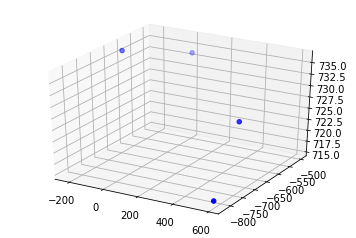

In [326]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
tmp1 = truth_hits[truth_hits.particle_id==684554015324770305]
ax.scatter(tmp1['x'].values, tmp1['y'].values, tmp1['z'].values, color='b')
#ax.scatter(tmp1['x'].values, tmp1['y'].values, z_pred, color='r')

In [10]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [79]:
mses = []
for particle_id in tqdm(truth_hits.particle_id.unique()):
    tmp1 = truth_hits[truth_hits.particle_id==particle_id]

    regr = linear_model.LinearRegression()
    regr.fit(tmp1[['x', 'y']].values, tmp1['z'].values)
    z_pred = regr.predict(tmp1[['x', 'y']].values)

    mses += [mean_squared_error(tmp1['z'].values, z_pred)]
mses = np.array(mses[1:])

100%|██████████| 10566/10566 [00:29<00:00, 360.32it/s]


In [107]:
truth_hits['r'] = np.sqrt(truth_hits['x'] ** 2 + truth_hits['y'] ** 2 + truth_hits['z'] ** 2 )
truth_hits['r0'] = np.sqrt(truth_hits['x'] ** 2 + truth_hits['y'] ** 2)

truth_hits['zr0'] = truth_hits['z'] / truth_hits['r0']
truth_hits['phi'] = np.arctan2(truth_hits['y'], truth_hits['x'])

In [121]:
#aa = a + dz * r
def rotate(alphas):
    x = truth_hits['x']
    y = truth_hits['y']
    phi = np.arccos(x/np.sqrt(x**2+y**2))
    r0 = truth_hits['r0']
    truth_hits['x_'] = r0 * np.cos(alphas - phi)
    truth_hits['y_'] = r0 * np.cos(np.pi / 2. - alphas + phi)

In [130]:
delta = 0.0006
alphas = delta * truth_hits['r0']
rotate(alphas)

In [24]:
for i in range(0, 60):
    dz = i * 0.00001

In [163]:
    #for i in range(0, 60):
    delta = 0.01

    alphas = delta * truth_hits['z']
    rotate(alphas)


    new_mses = []
    for particle_id in tqdm(truth_hits.particle_id.unique()):
        tmp1 = truth_hits[truth_hits.particle_id==particle_id]

        regr = linear_model.LinearRegression()
        regr.fit(tmp1[['x_', 'y_']].values, tmp1['z'].values)
        z_pred = regr.predict(tmp1[['x_', 'y_']].values)

        new_mses += [mean_squared_error(tmp1['z'].values, z_pred)]
    new_mses = np.array(new_mses[1:])

100%|██████████| 10566/10566 [00:51<00:00, 204.98it/s]


In [164]:
tmp = np.vstack([mses, new_mses]).T
#mses - np.min(mses, new_mses, axis=1)
(tmp[:, 0] - tmp.min(axis=1) ).mean()

799.5475

In [309]:
tmp[:,0][tmp[:, 0]>100]

array([  62450.816  ,     116.2152 ,  129507.38   ,     125.18352,
           137.94669,     134.073  ,   23940.969  ,     108.47765,
           252.81389,   90268.14   , ...,   10825.033  ,  310697.25   ,
           105.8904 ,     196.25032,    3198.6475 ,     507.7386 ,
         28306.264  ,     322.3659 ,     285.8892 , 1166031.9    ],
      dtype=float32)

In [324]:
np.where(mses == 310697.25)

(array([10169]),)

In [325]:
truth_hits.particle_id.unique()[10169]

684554015324770305

In [ ]:
799.5475
621.0475
416.48856
211.70251

In [168]:
def merge(cl1, cl2, min_cnt): # merge cluster 2 to cluster 1
    d = pd.DataFrame(data={'s1':cl1,'s2':cl2})
    d['N1'] = d.groupby('s1')['s1'].transform('count')
    d['N2'] = d.groupby('s2')['s2'].transform('count')
    maxs1 = d['s1'].max()
    cond = np.where((d['N2'].values>d['N1'].values) & (d['N2'].values<20) &  (d['N2'].values>min_cnt))
    #cond = np.where((d['N2'].values>d['N1'].values) & (d['N2'].values<20) )

    s1 = d['s1'].values 
    s1[cond] = d['s2'].values[cond]+maxs1 
    return s1

In [302]:
from trackml.dataset import load_event, load_dataset
from trackml.score import score_event

from sklearn.cluster.dbscan_ import dbscan
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import numpy as np
import pandas as pd
import timeit
import multiprocessing
from multiprocessing import Pool

def find_labels(params):
    hits, dz = params
    a = hits['phi'].values
    z = hits['z'].values
    zr0 = hits['zr0'].values

    r = hits['r0'].values
    
    aa = a + np.sign(z) * dz * z
    #aa = a + dz * r
    #aa = a + dz * ( 0.001 *r ** 2 + r)
    #aa = a + np.nan_to_num(np.arccos(dz * r))

    f0 = np.cos(aa)
    f1 = np.sin(aa)
    f2 = hits['f2'].values
    f3 = zr0
    X = StandardScaler().fit_transform(np.column_stack([f0, f1, f3]))

    _, l = dbscan(X,  eps=0.0045, min_samples=1, n_jobs=8)
    return l + 1

def add_count(l):
    unique, reverse, count = np.unique(l, return_counts=True, return_inverse=True)
    c = count[reverse]
    c[np.where(l == 0)] = 0
    c[np.where(c > 20)] = 0
    return (l, c)

def do_dbscan_predict(hits, z_shift, space):
    start_time = timeit.default_timer()

    hits['z_shifted'] = hits['z'] #- z_shift
    
    hits['r'] = np.sqrt(hits['x'] ** 2 + hits['y'] ** 2 + hits['z_shifted'] ** 2 )
    hits['r0'] = np.sqrt(hits['x'] ** 2 + hits['y'] ** 2)

    hits['zr0'] = hits['z_shifted'] / hits['r0']
    hits['phi'] = np.arctan2(hits['y'], hits['x'])
    hits['tmp'] = hits['r']/(2*hits['r0'])
    

    #scaler = MinMaxScaler(feature_range=(-1, 1))
    #hits['tmp'] = scaler.fit_transform(hits['tmp'].values.reshape(len(hits['tmp']), 1))
    #hits['tmp'] = hits['tmp'].apply(lambda x: min(0.99999, x))
    hits['f2'] = np.arctan(   hits['tmp']   )
    
    
    params = []
#     for i in range(0, 500):
#         dz = i * 0.00001
    #for dz in [0.001]:
    #for dz in [0.0002]:
    #for dz in np.linspace(0.0, 0.0002, 60):
    for dz in space:
        params.append((hits, dz))
        if dz > 0:
             params.append((hits, -dz))

             
    pool = Pool(processes=8)
    labels_for_all_steps = pool.map(find_labels, params)
    #results = [add_count(l) for l in labels_for_all_steps]
    results = labels_for_all_steps
    pool.close()

    labels = results[0]
    for i in range(1, len(results)):
        labels = merge(labels, results[i], 0)

#     labels, counts = results[0]
#     for i in range(1, len(results)):
#         l, c = results[i]
#         idx = np.where((c - counts > 0))[0]
#         labels[idx] = l[idx] + labels.max()
#         counts[idx] = c[idx]

    #print('time spent:', timeit.default_timer() - start_time, z_shift)

    return labels, results

def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

def run_dbscan(space):
    data_dir = '../input/train_1'

    sum = 0
    sum_score = 0

    z_result = []
    #its, cells, particles, truth = load_event(data_dir + '/event' + event_id)
    #for z_shift in range(-100, 101):
    for z_shift in range(1):
      
        labels, results = do_dbscan_predict(hits,  z_shift * 0.055, space)
        z_result += [labels]
        
    labels = z_result[0]
    for i in range(1, len(z_result)):
        labels = merge(labels, z_result[i], 0)        

        
    submission = create_one_event_submission(0, hits['hit_id'].values, labels)
    score = score_event(truth, submission)
    print(score)
    sum_score += score
    sum += 1

    #print('--------------------------------------')
    #print(sum_score / sum)
    
    return score

In [237]:
%%time
z_result1, labels1, submission = run_dbscan([0])

0.07207108623356426
CPU times: user 1.02 s, sys: 112 ms, total: 1.14 s
Wall time: 2.02 s


In [ ]:
%%time
z_result1, labels1, submission = run_dbscan([0])

In [283]:
pool = Pool(processes=8)

import threading
lock = threading.Lock()

score = []
for df in tqdm(pool.imap_unordered(run_dbscan,  np.linspace(0, 0.0006, 60))):
    score += [df]
    None
    
pool.close()

0it [00:00, ?it/s]

TypeError: 'numpy.float64' object is not iterable

In [303]:
score = []
for k in np.linspace(0, 0.0006, 60):
    score += [run_dbscan([k])]

0.07207108623356426
0.11151416821480101
0.14113084209670967
0.1404475534555976
0.1147461980967881
0.09124264068002749
0.07855301683644075
0.06757262059494612
0.05967727386224379
0.049309793479157295
0.04067658866236426
0.03542492627421595
0.03191007205419599
0.030513603597218684
0.027644817372884746
0.025486914229814295
0.02527616504084904
0.024164843447958613
0.023161038453173948
0.02356607223548609
0.021948632025828873
0.020597859541250114
0.021552108456206934
0.02187695375230582
0.021379107628355265
0.021806925054887544
0.021240289853043246
0.02085026820231467
0.019871036744251128
0.017786602937269715
0.017782274128084388
0.01662068823043539
0.014384513191274397
0.014185005564175776
0.014059537191911504
0.013215698092020821
0.015079317483458135
0.014532922394600611
0.015001257860715154
0.015291424004670958
0.014414129916207837
0.01361857209213371
0.012865582735602246
0.013187621432065462
0.012915257347153153
0.013662431453332017
0.013523654494780404
0.013560228315948848
0.0112996523

In [304]:
a0 = score.copy()

In [258]:
a1 = score.copy()

In [262]:
a2 = score.copy()

In [297]:
a3 = score.copy()

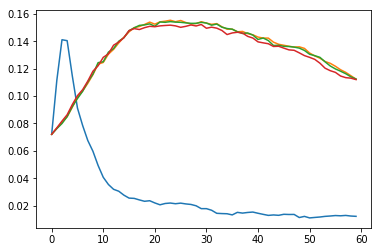

In [305]:
plt.plot(a0)
plt.plot(a1)
plt.plot(a2)
plt.plot(a3)

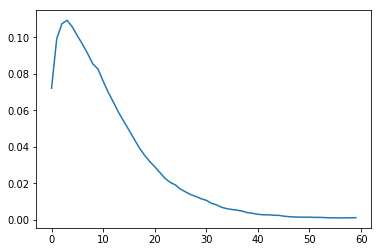

In [250]:
plt.plot(score)

In [264]:
%%time
run_dbscan(np.linspace(0, 0.0006, 60))

0.38631599858068083
CPU times: user 2.78 s, sys: 348 ms, total: 3.13 s
Wall time: 27.6 s


0.38631599858068083

In [301]:
%%time
run_dbscan(np.linspace(0, 0.001, 100))

0.2840448729638545
CPU times: user 4.08 s, sys: 436 ms, total: 4.52 s
Wall time: 45.3 s


0.2840448729638545

In [ ]:
0.07712113964927175
0.03033270452136469

In [ ]:
0.11
0.042249266396855015
0.01260023562646806